In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Concatenate
from CNN_PY import cnn_model
from LSTM_PY import lstm_model
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import keras
import joblib
import ta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.preprocessing import image
from PIL import Image
import mplfinance as mpf
import os
from datetime import timedelta
import time
from tqdm import tqdm
import csv

def load_data_from_csv(symbol, start_date, end_date, csv_path='sp500_latest.csv'):
    # CSV 파일 전체 로드
    df_all = pd.read_csv(csv_path, parse_dates=['Date'])
    
    # Symbol 필터링 & Date 범위 필터링
    df = df_all[
        (df_all['Symbol'] == symbol) &
        (df_all['Date'] >= pd.to_datetime(start_date)) &
        (df_all['Date'] <= pd.to_datetime(end_date))
    ].copy()
    
    # 인덱스를 Date로 설정 (yf.download 결과와 비슷하게)
    df.set_index('Date', inplace=True)
    
    # 필요하면 Column 순서 정리
    # df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    return df

In [9]:
'''
import pandas as pd

# 전체 S&P500 최신 데이터 로딩
df_all = pd.read_csv('sp500_latest.csv', parse_dates=['Date'])

# 원하는 기간 필터 (2024-01-01 ~ 2024-12-31)
df_filtered = df_all[(df_all['Date'] >= '2024-01-01') & (df_all['Date'] < '2025-01-01')]

# 필요한 칼럼 생성 및 초기화
df_mlp_init = df_filtered[['Symbol', 'Date']].copy()
df_mlp_init['Close'] = ''  # 예측값 저장용 → 초기 빈값
df_mlp_init['Label'] = ''  # 예측 Label → 빈값
df_mlp_init['Prob'] = ''   # 예측 확률 → 빈값
df_mlp_init['Actual_Close'] = df_filtered['Close']  # 실제 종가만 채워 넣음

# 저장
df_mlp_init.to_csv('MLP_sp500.csv', index=False)
print("✅ MLP_sp500.csv 초기화 완료 (Close 비워지고, Actual_Close만 채워짐)")
'''

'''
ticker = 'AAPL'
model_path = os.path.join('LSTM_MODEL_H5_WIN', f'{ticker}.h5')
model = tf.keras.models.load_model(model_path, compile=False)
model.summary()
'''

"\nticker = 'AAPL'\nmodel_path = os.path.join('LSTM_MODEL_H5_WIN', f'{ticker}.h5')\nmodel = tf.keras.models.load_model(model_path, compile=False)\nmodel.summary()\n"

In [ ]:
# MLP 학습할 데이터셋 구축 (NEW)

import pandas as pd
import numpy as np
import yfinance as yf
import csv
import os
from datetime import datetime, timedelta
from CNN_PY import cnn_model
from LSTM_PY import lstm_model
import time

# 파일 경로
symbols_file = 'symbols_part0.txt' #completed_symbols_h5.txt'
output_csv = 'MLP_sp500_2.csv'

# 기간
start_date = '2024-03-12' # 01-01
end_date = '2025-01-01'
buffer_days = 150
read_start_date = pd.to_datetime(start_date) - pd.Timedelta(days=buffer_days)


# 초기 CSV 파일 존재 확인 및 중복 키 확보
if os.path.exists(output_csv):
    existing_df = pd.read_csv(output_csv)
    existing_keys = set(existing_df.apply(lambda x: f"{x['Symbol']}_{x['Date']}", axis=1))
else:
    # 파일 없으면 헤더 생성
    with open(output_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Symbol', 'Date', 'Close', 'Label', 'Actual_Close'])
    existing_keys = set()

# 종목 리스트 로드
with open(symbols_file, 'r') as f:
    symbols = [line.strip() for line in f.readlines() if line.strip()]


for symbol in symbols:
    print(f"\n### {symbol} 처리 시작 ###")
    try:
        # CSV에서 한번만 데이터 로드
        df = load_data_from_csv(symbol, read_start_date, end_date)
        if df.empty:
            print(f"{symbol}: 기간 내 데이터 없음")
            continue
        
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [col[0] for col in df.columns]

        df = df.dropna(subset=['Close']).copy()
        df['Date_Str'] = df.index.strftime('%Y-%m-%d')

        # 거래일별 처리
        for idx, row in df.iterrows():
            date = row['Date_Str']
            
            # 2024-01-01 이전은 예측 안함
            if pd.to_datetime(date) < pd.to_datetime(start_date):
                continue

            key = f"{symbol}_{date}"

            if key in existing_keys:
                print(f"{symbol} {date}: 이미 존재, 스킵")
                continue

            try:
                # LSTM 예측 (df 전달)
                close = lstm_model(date, symbol, df)
                if close is None:
                    print(f"{symbol} {date}: LSTM 예측 실패")
                    continue

                # CNN 예측 (df 전달) prob 없이 label만 받음
                label = cnn_model(date, symbol, df)
                if label is None:
                    print(f"{symbol} {date}: CNN 예측 실패")
                    continue

                # 실제 종가 (df에서 사용)
                actual_close = row['Close']

                print(f"{symbol} | {date} | Close(LSTM): {close:.2f} | Label: {label} | Actual_Close: {actual_close:.2f}")

                # CSV 기록
                with open(output_csv, 'a', newline='') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow([symbol, date, close, label, actual_close])

                existing_keys.add(key)

            except Exception as e:
                print(f"{symbol} {date} 처리 오류: {e}")

            # time.sleep(0.5)  # API 딜레이 불필요하지만, 안전하게 유지

    except Exception as e:
        print(f"{symbol} 전체 처리 오류: {e}")

print("\n### 전체 완료 ###")





Epoch 1/100


c:\Users\pyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4493/4504 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 6.5708e-04 - mae: 0.0053Epoch 1 | Train sMAPE: 15.50% | Val sMAPE: 15.19% | Test sMAPE: 15.47%
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 5s 952us/step - loss: 6.5563e-04 - mae: 0.0053 - val_loss: 3.8490e-06 - val_mae: 0.0014
Epoch 2/100
4452/4504 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 8.9875e-06 - mae: 0.0014Epoch 2 | Train sMAPE: 33.51% | Val sMAPE: 33.10% | Test sMAPE: 33.46%
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 4s 901us/step - loss: 8.9911e-06 - mae: 0.0014 - val_loss: 1.3715e-05 - val_mae: 0.0034
Epoch 3/100
4456/4504 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 9.6429e-06 - mae: 0.0015Epoch 3 | Train sMAPE: 13.49% | Val sMAPE: 13.42% | Test sMAPE: 13.44%
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 4s 915us/step - loss: 9.6318e-06 - mae: 0.0015 - val_loss: 2.7721e-06 - val_mae: 8.8376e-04
Epoch 4/100
4472/4504 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 6.3309e-06 - mae: 0.0012Epoch 4 | Train sMAPE: 3.48% | Val sMAPE: 3.42% | Test sMAPE: 3.43%
4504/4504 ━━━━

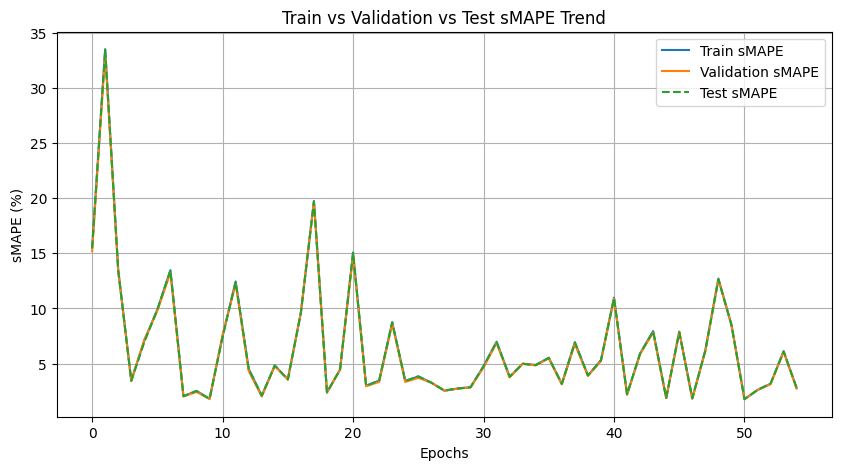

626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step

[최종 Test 평가] sMAPE: 1.89%, MAE: 2.8116


In [8]:
# MLP Training Original (including Label Scalering)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import joblib

# 1. 데이터 로드 & 전처리
# df = pd.read_csv('MLP_sp500_united.csv')

#
df = pd.read_csv('MLP_sp500_weird.csv')
df = df.dropna(subset=['Close', 'Label', 'Yes_Close', 'Actual_Close']).reset_index(drop=True)
#

features = ['Close', 'Label', 'Yes_Close']
X = df[features].values
y = df['Actual_Close'].values.reshape(-1, 1)

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 2. 커스텀 sMAPE 콜백 정의
class SMAPETracker(Callback):
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test, y_scaler):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.y_scaler = y_scaler
        self.history = {'train_smape': [], 'val_smape': [], 'test_smape': []}

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.X_train, verbose=0)
        y_val_pred = self.model.predict(self.X_val, verbose=0)
        y_test_pred = self.model.predict(self.X_test, verbose=0)

        y_train_true = self.y_scaler.inverse_transform(self.y_train)
        y_val_true = self.y_scaler.inverse_transform(self.y_val)
        y_test_true = self.y_scaler.inverse_transform(self.y_test)
        y_train_pred = self.y_scaler.inverse_transform(y_train_pred)
        y_val_pred = self.y_scaler.inverse_transform(y_val_pred)
        y_test_pred = self.y_scaler.inverse_transform(y_test_pred)

        train_smape = np.mean(2.0 * np.abs(y_train_true - y_train_pred) / 
                              (np.abs(y_train_true) + np.abs(y_train_pred))) * 100
        val_smape = np.mean(2.0 * np.abs(y_val_true - y_val_pred) / 
                            (np.abs(y_val_true) + np.abs(y_val_pred))) * 100
        test_smape = np.mean(2.0 * np.abs(y_test_true - y_test_pred) / 
                             (np.abs(y_test_true) + np.abs(y_test_pred))) * 100

        self.history['train_smape'].append(train_smape)
        self.history['val_smape'].append(val_smape)
        self.history['test_smape'].append(test_smape)

        print(f"Epoch {epoch+1} | Train sMAPE: {train_smape:.2f}% | Val sMAPE: {val_smape:.2f}% | Test sMAPE: {test_smape:.2f}%")


# 3. 검증셋 따로 나누기
val_size = int(0.1 * len(X_train))
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train_sub, y_train_sub = X_train[val_size:], y_train[val_size:]

# 4. MLP 모델 정의
mlp = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 5. EarlyStopping + sMAPE Tracker
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
smape_tracker = SMAPETracker(X_train_sub, y_train_sub, X_val, y_val, X_test, y_test, y_scaler)

# 6. 훈련
mlp.fit(X_train_sub, y_train_sub, epochs=100, batch_size=16, 
        validation_data=(X_val, y_val), callbacks=[early_stop, smape_tracker])

# 8. 모델 & 스케일러 저장
# mlp.save('MLP_model_3.h5')
# joblib.dump(X_scaler, 'MLP_X_scaler_3.joblib')
# joblib.dump(y_scaler, 'MLP_y_scaler_3.joblib')

# 7. sMAPE 트렌드 시각화
plt.figure(figsize=(10, 5))
plt.plot(smape_tracker.history['train_smape'], label='Train sMAPE')
plt.plot(smape_tracker.history['val_smape'], label='Validation sMAPE')
plt.plot(smape_tracker.history['test_smape'], label='Test sMAPE', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('sMAPE (%)')
plt.title('Train vs Validation vs Test sMAPE Trend')
plt.legend()
plt.grid(True)
plt.show()


# 8. 테스트셋 평가
y_test_pred = mlp.predict(X_test)
y_test_rescaled = y_scaler.inverse_transform(y_test)
y_test_pred_rescaled = y_scaler.inverse_transform(y_test_pred)

test_smape = np.mean(2.0 * np.abs(y_test_rescaled - y_test_pred_rescaled) / 
                     (np.abs(y_test_rescaled) + np.abs(y_test_pred_rescaled))) * 100
test_mae = np.mean(np.abs(y_test_rescaled - y_test_pred_rescaled))

print(f"\n[최종 Test 평가] sMAPE: {test_smape:.2f}%, MAE: {test_mae:.4f}")


Epoch 1/100


c:\Users\pyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4393/4504 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 3.6762e-04 - mae: 0.0041Epoch 1 | Train sMAPE: 7.58% | Val sMAPE: 7.37%
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 4s 885us/step - loss: 3.6010e-04 - mae: 0.0040 - val_loss: 6.3449e-06 - val_mae: 8.3362e-04
Epoch 2/100
4462/4504 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 1.2463e-05 - mae: 0.0016Epoch 2 | Train sMAPE: 5.00% | Val sMAPE: 4.92%
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 4s 847us/step - loss: 1.2442e-05 - mae: 0.0016 - val_loss: 3.0342e-06 - val_mae: 5.9839e-04
Epoch 3/100
4501/4504 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 6.9934e-06 - mae: 0.0012Epoch 3 | Train sMAPE: 2.62% | Val sMAPE: 2.61%
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 4s 855us/step - loss: 6.9945e-06 - mae: 0.0012 - val_loss: 1.1146e-06 - val_mae: 4.1397e-04
Epoch 4/100
4433/4504 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 4.3290e-06 - mae: 9.6554e-04Epoch 4 | Train sMAPE: 4.26% | Val sMAPE: 4.25%
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 4s 893us/step - loss: 4.3579e-06 - mae: 9.6838e-04 - val_los

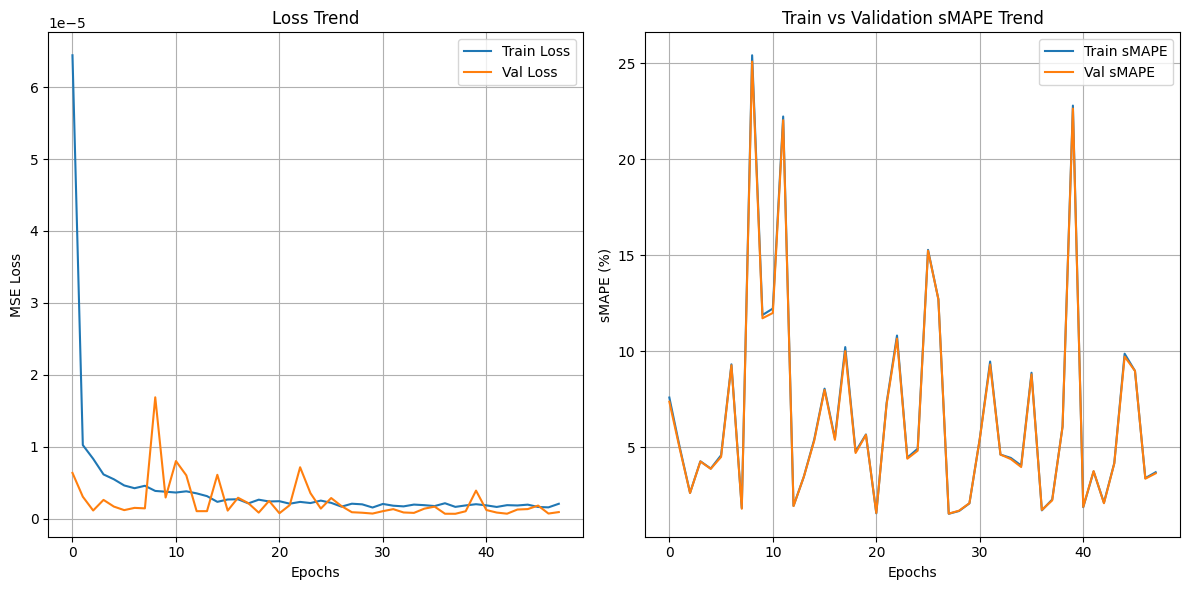

626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step

[최종 Test 평가] sMAPE: 2.29%, MAE: 2.8589


In [6]:
# MLP Training Original + 시각화 (including Label Scalering)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib

# 1. 데이터 로드 & 전처리
# df = pd.read_csv('MLP_sp500_completed.csv')
df = pd.read_csv('MLP_sp500_weird.csv')
df = df.dropna(subset=['Close', 'Label', 'Yes_Close', 'Actual_Close']).reset_index(drop=True)

features = ['Close', 'Label', 'Yes_Close']
X = df[features].values
y = df['Actual_Close'].values.reshape(-1, 1)

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 2. 검증셋 따로 나누기
val_size = int(0.1 * len(X_train))
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train_sub, y_train_sub = X_train[val_size:], y_train[val_size:]

# 3. 커스텀 sMAPE 콜백 정의 (Test 제외)
class SMAPETracker(Callback):
    def __init__(self, X_train, y_train, X_val, y_val, y_scaler):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.y_scaler = y_scaler
        self.history = {'train_smape': [], 'val_smape': []}

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.X_train, verbose=0)
        y_val_pred = self.model.predict(self.X_val, verbose=0)

        y_train_true = self.y_scaler.inverse_transform(self.y_train)
        y_val_true = self.y_scaler.inverse_transform(self.y_val)
        y_train_pred = self.y_scaler.inverse_transform(y_train_pred)
        y_val_pred = self.y_scaler.inverse_transform(y_val_pred)

        train_smape = np.mean(2.0 * np.abs(y_train_true - y_train_pred) / 
                              (np.abs(y_train_true) + np.abs(y_train_pred))) * 100
        val_smape = np.mean(2.0 * np.abs(y_val_true - y_val_pred) / 
                            (np.abs(y_val_true) + np.abs(y_val_pred))) * 100

        self.history['train_smape'].append(train_smape)
        self.history['val_smape'].append(val_smape)

        print(f"Epoch {epoch+1} | Train sMAPE: {train_smape:.2f}% | Val sMAPE: {val_smape:.2f}%")

# 4. MLP 모델 정의
mlp = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 5. EarlyStopping + sMAPE Tracker
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
smape_tracker = SMAPETracker(X_train_sub, y_train_sub, X_val, y_val, y_scaler)

# 6. 훈련
history = mlp.fit(X_train_sub, y_train_sub, 
                  epochs=100, 
                  batch_size=16, 
                  validation_data=(X_val, y_val), 
                  callbacks=[early_stop, smape_tracker])

# # 7. 모델 & 스케일러 저장
# mlp.save('MLP_model_3.h5')
# joblib.dump(X_scaler, 'MLP_X_scaler_3.joblib')
# joblib.dump(y_scaler, 'MLP_y_scaler_3.joblib')

# 8. 성능 시각화
plt.figure(figsize=(12, 6))

# Loss 시각화
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Loss Trend')
plt.legend()
plt.grid(True)

# sMAPE 시각화
plt.subplot(1, 2, 2)
plt.plot(smape_tracker.history['train_smape'], label='Train sMAPE')
plt.plot(smape_tracker.history['val_smape'], label='Val sMAPE')
plt.xlabel('Epochs')
plt.ylabel('sMAPE (%)')
plt.title('Train vs Validation sMAPE Trend')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 9. 테스트셋 최종 평가
y_test_pred = mlp.predict(X_test)
y_test_rescaled = y_scaler.inverse_transform(y_test)
y_test_pred_rescaled = y_scaler.inverse_transform(y_test_pred)

test_smape = np.mean(2.0 * np.abs(y_test_rescaled - y_test_pred_rescaled) /
                     (np.abs(y_test_rescaled) + np.abs(y_test_pred_rescaled))) * 100
test_mae = np.mean(np.abs(y_test_rescaled - y_test_pred_rescaled))

print(f"\n[최종 Test 평가] sMAPE: {test_smape:.2f}%, MAE: {test_mae:.4f}")


Epoch 1/100


c:\Users\pyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4451/4504 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 1.2504e-04 - mae: 0.0030Epoch 1 | Train sMAPE: 22.79%, Val sMAPE: 22.30% | Train MAE: 13.6782, Val MAE: 13.7583 | Train RMSE: 19.2704, Val RMSE: 19.7628 | Train R²: 0.9984, Val R²: 0.9979
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 5s 889us/step - loss: 1.2396e-04 - mae: 0.0030 - val_loss: 3.9708e-06 - val_mae: 0.0014
Epoch 2/100
4395/4504 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 1.6241e-05 - mae: 0.0017Epoch 2 | Train sMAPE: 3.63%, Val sMAPE: 3.60% | Train MAE: 5.8308, Val MAE: 5.8113 | Train RMSE: 13.4750, Val RMSE: 13.2617 | Train R²: 0.9992, Val R²: 0.9991
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 4s 866us/step - loss: 1.6129e-05 - mae: 0.0017 - val_loss: 1.7880e-06 - val_mae: 5.8595e-04
Epoch 3/100
4502/4504 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 7.3817e-06 - mae: 0.0012Epoch 3 | Train sMAPE: 19.77%, Val sMAPE: 19.49% | Train MAE: 18.5753, Val MAE: 18.3404 | Train RMSE: 23.5127, Val RMSE: 22.5030 | Train R²: 0.9976, Val R²: 0.9973
4504/4504 ━━━━━

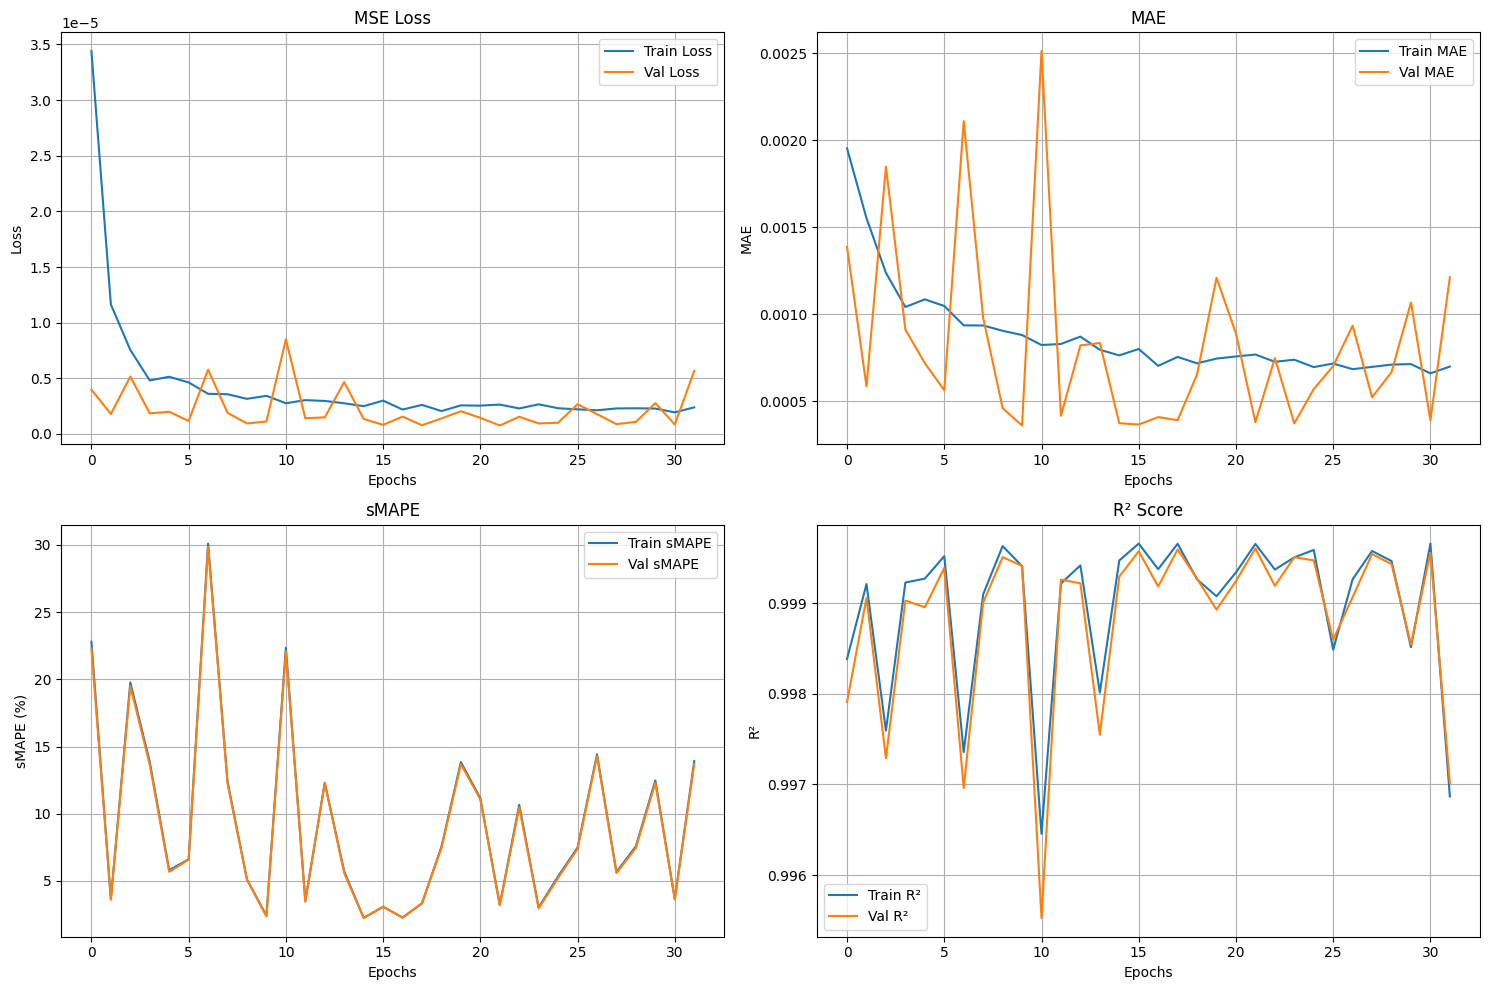

626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step

[최종 Test 평가]
sMAPE: 3.20%
MAE: 3.7268
MSE: 83.5827
RMSE: 9.1424
R²: 0.9996


In [5]:
# Label 정규화 없이 진행 테스트 + 시각화 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# sMAPE 함수 정의
def sMAPE(y_true, y_pred):
    return np.mean(2.0 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# 1. 데이터 로드 & 전처리
df = pd.read_csv('MLP_sp500_weird.csv')
df = df.dropna(subset=['Close', 'Label', 'Yes_Close', 'Actual_Close']).reset_index(drop=True)

# Label은 정규화 없이 그대로, Close와 Yes_Close만 스케일링
features_to_scale = ['Close', 'Yes_Close']
features = features_to_scale + ['Label']

X_raw = df[features].copy()
y_raw = df['Actual_Close'].values.reshape(-1, 1)

# 스케일러 준비
scaler_X = MinMaxScaler()
X_scaled_part = scaler_X.fit_transform(X_raw[features_to_scale])
# Label은 정규화 없이 그대로 붙임
X_scaled = np.hstack([X_scaled_part, X_raw[['Label']].values])

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_raw)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# val 분리
val_size = int(0.1 * len(X_train))
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train_sub, y_train_sub = X_train[val_size:], y_train[val_size:]

# 2. Metrics 콜백 정의
class MetricsTracker(Callback):
    def __init__(self, X_train, y_train, X_val, y_val, y_scaler):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.y_scaler = y_scaler
        self.history = {
            'train_smape': [], 'val_smape': [],
            'train_mae': [], 'val_mae': [],
            'train_mse': [], 'val_mse': [],
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': []
        }

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.X_train, verbose=0)
        y_val_pred = self.model.predict(self.X_val, verbose=0)

        # 역정규화
        y_train_true = self.y_scaler.inverse_transform(self.y_train)
        y_train_pred = self.y_scaler.inverse_transform(y_train_pred)
        y_val_true = self.y_scaler.inverse_transform(self.y_val)
        y_val_pred = self.y_scaler.inverse_transform(y_val_pred)

        # 지표 계산
        train_smape = sMAPE(y_train_true, y_train_pred)
        val_smape = sMAPE(y_val_true, y_val_pred)

        train_mae = mean_absolute_error(y_train_true, y_train_pred)
        val_mae = mean_absolute_error(y_val_true, y_val_pred)

        train_mse = mean_squared_error(y_train_true, y_train_pred)
        val_mse = mean_squared_error(y_val_true, y_val_pred)

        train_rmse = np.sqrt(train_mse)
        val_rmse = np.sqrt(val_mse)

        train_r2 = r2_score(y_train_true, y_train_pred)
        val_r2 = r2_score(y_val_true, y_val_pred)

        # 기록 저장
        self.history['train_smape'].append(train_smape)
        self.history['val_smape'].append(val_smape)
        self.history['train_mae'].append(train_mae)
        self.history['val_mae'].append(val_mae)
        self.history['train_mse'].append(train_mse)
        self.history['val_mse'].append(val_mse)
        self.history['train_rmse'].append(train_rmse)
        self.history['val_rmse'].append(val_rmse)
        self.history['train_r2'].append(train_r2)
        self.history['val_r2'].append(val_r2)

        print(
            f"Epoch {epoch+1} | "
            f"Train sMAPE: {train_smape:.2f}%, Val sMAPE: {val_smape:.2f}% | "
            f"Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f} | "
            f"Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f} | "
            f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}"
        )

# 3. 모델 정의 및 컴파일
mlp = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 4. 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
metrics_tracker = MetricsTracker(X_train_sub, y_train_sub, X_val, y_val, scaler_y)

# 5. 학습
history = mlp.fit(X_train_sub, y_train_sub,
                  epochs=100,
                  batch_size=16,
                  validation_data=(X_val, y_val),
                  callbacks=[early_stop, metrics_tracker])

# 6. 모델 및 스케일러 저장
# mlp.save('MLP_model_3.h5')
# joblib.dump(scaler_X, 'MLP_X_scaler_3.joblib')
# joblib.dump(scaler_y, 'MLP_y_scaler_3.joblib')

# 7. 시각화
plt.figure(figsize=(15, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# MAE
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid()

# sMAPE
plt.subplot(2, 2, 3)
plt.plot(metrics_tracker.history['train_smape'], label='Train sMAPE')
plt.plot(metrics_tracker.history['val_smape'], label='Val sMAPE')
plt.title('sMAPE')
plt.xlabel('Epochs')
plt.ylabel('sMAPE (%)')
plt.legend()
plt.grid()

# R²
plt.subplot(2, 2, 4)
plt.plot(metrics_tracker.history['train_r2'], label='Train R²')
plt.plot(metrics_tracker.history['val_r2'], label='Val R²')
plt.title('R² Score')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# 8. 테스트셋 평가
y_test_pred = mlp.predict(X_test)
y_test_true = scaler_y.inverse_transform(y_test)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)

test_smape = sMAPE(y_test_true, y_test_pred_rescaled)
test_mae = mean_absolute_error(y_test_true, y_test_pred_rescaled)
test_mse = mean_squared_error(y_test_true, y_test_pred_rescaled)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_true, y_test_pred_rescaled)

print(f"\n[최종 Test 평가]")
print(f"sMAPE: {test_smape:.2f}%")
print(f"MAE: {test_mae:.4f}")
print(f"MSE: {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²: {test_r2:.4f}")


In [ ]:
# # 실제 MLP 호출해서 예측값 얻는 코드

# import tensorflow as tf
# import joblib
# import numpy as np

# # 
# # 1. 모델과 스케일러 로드
# model = tf.keras.models.load_model('MLP_model_3.h5', compile=False)
# X_scaler = joblib.load('MLP_X_scaler_3.joblib')
# y_scaler = joblib.load('MLP_y_scaler_3.joblib')
# Close = 140.36799600252607
# Label = 0.0695935785770416
# Yes_Close = 139.4499969482422
# # 2. 예측할 새 데이터 (예시 값)
# new_data = np.array([[Close, Label, Yes_Close]])  # [Close, Label, Yes_Close]

# # 3. 스케일링
# new_data_scaled = X_scaler.transform(new_data)

# # 4. 예측
# prediction_scaled = model.predict(new_data_scaled)

# # 5. 역스케일링
# prediction = y_scaler.inverse_transform(prediction_scaled)
# print(f"예측된 최종 종가값: {prediction[0][0]:.2f}")
# # 137.13999938964844

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
예측된 최종 종가값: 213.95


In [ ]:
# # MLP_sp500_2  ->  MLP_sp500_completed

# import pandas as pd

# # 1. Load CSV
# df = pd.read_csv("MLP_sp500_2.csv")
# df['Date'] = pd.to_datetime(df['Date'])

# # 2. Load symbol order
# symbols_order = [line.strip() for line in open("completed_symbols_h5.txt", "r")]
# symbol_to_order = {symbol: i for i, symbol in enumerate(symbols_order)}

# # 3. Sort for correct lagging
# df = df.sort_values(by=['Symbol', 'Date'])

# # 4. Generate 'Yes_Close' using shift
# df['Yes_Close'] = df.groupby('Symbol')['Actual_Close'].shift(1)

# # 5. Keep rows where Date >= 2024-03-13 (but shift uses 3월 12일까지 필요하므로 순서 중요)
# filtered_df = df[df['Date'] >= pd.to_datetime("2024-03-13")].copy()

# # 6. Reorder columns as requested
# filtered_df = filtered_df[['Symbol', 'Date', 'Close', 'Label', 'Yes_Close', 'Actual_Close']]

# # 7. Apply sorting by symbol order and ascending date
# filtered_df['SymbolOrder'] = filtered_df['Symbol'].map(symbol_to_order)
# filtered_df = filtered_df.sort_values(by=['SymbolOrder', 'Date']).drop(columns='SymbolOrder')

# # 8. Save final CSV
# filtered_df.to_csv("MLP_sp500_completed.csv", index=False)


In [ ]:
'''
# # MLP 학습할 데이터셋 구축 (ORIGINAL)

# import pandas as pd
# import numpy as np
# import yfinance as yf
# import csv
# import os
# from datetime import datetime, timedelta
# from CNN_PY import cnn_model
# from LSTM_PY import lstm_model
# import time

# # 파일 경로
# symbols_file = 'completed_symbols_h5.txt'
# output_csv = 'MLP_sp500.csv'

# # 기간
# start_date = '2024-01-01'
# end_date = '2025-01-01'
# buffer_days = 150
# read_start_date = pd.to_datetime(start_date) - pd.Timedelta(days=buffer_days)

# print(read_start_date)

# # 초기 CSV 파일 존재 확인 및 중복 키 확보
# if os.path.exists(output_csv):
#     existing_df = pd.read_csv(output_csv)
#     existing_keys = set(existing_df.apply(lambda x: f"{x['Symbol']}_{x['Date']}", axis=1))
# else:
#     # 파일 없으면 헤더 생성
#     with open(output_csv, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['Symbol', 'Date', 'Close', 'Label', 'Prob', 'Actual_Close'])
#     existing_keys = set()

# # 종목 리스트 로드
# with open(symbols_file, 'r') as f:
#     symbols = [line.strip() for line in f.readlines() if line.strip()]


# for symbol in symbols:
#     print(f"\n### {symbol} 처리 시작 ###")
#     try:
#         # CSV에서 한번만 데이터 로드
#         df = load_data_from_csv(symbol, read_start_date, end_date)
#         if df.empty:
#             print(f"{symbol}: 기간 내 데이터 없음")
#             continue
        
#         if isinstance(df.columns, pd.MultiIndex):
#             df.columns = [col[0] for col in df.columns]

#         df = df.dropna(subset=['Close']).copy()
#         df['Date_Str'] = df.index.strftime('%Y-%m-%d')

#         # 거래일별 처리
#         for idx, row in df.iterrows():
#             date = row['Date_Str']
            
#             # 2024-01-01 이전은 예측 안함
#             if pd.to_datetime(date) < pd.to_datetime(start_date):
#                 continue

#             key = f"{symbol}_{date}"

#             if key in existing_keys:
#                 print(f"{symbol} {date}: 이미 존재, 스킵")
#                 continue

#             try:
#                 # LSTM 예측 (df 전달)
#                 close = lstm_model(date, symbol, df)
#                 if close is None:
#                     print(f"{symbol} {date}: LSTM 예측 실패")
#                     continue

#                 # CNN 예측 (df 전달)
#                 label, prob = cnn_model(date, symbol, df)
#                 if label is None or prob is None:
#                     print(f"{symbol} {date}: CNN 예측 실패")
#                     continue

#                 # 실제 종가 (df에서 사용)
#                 actual_close = row['Close']

#                 print(f"{symbol} | {date} | Close(LSTM): {close:.2f} | Label: {label} | Prob: {prob:.4f} | Actual_Close: {actual_close:.2f}")

#                 # CSV 기록
#                 with open(output_csv, 'a', newline='') as csvfile:
#                     writer = csv.writer(csvfile)
#                     writer.writerow([symbol, date, close, label, prob, actual_close])

#                 existing_keys.add(key)

#             except Exception as e:
#                 print(f"{symbol} {date} 처리 오류: {e}")

#             # time.sleep(0.5)  # API 딜레이 불필요하지만, 안전하게 유지

#     except Exception as e:
#         print(f"{symbol} 전체 처리 오류: {e}")

# print("\n### 전체 완료 ###")
'''


'''
# # 종목별 처리
# for symbol in symbols:
#     print(f"\n### {symbol} 처리 시작 ###")
#     try:
#         # 한번만 데이터 다운로드 (전체 거래일 확보)
#         df = yf.download(symbol, start=start_date, end=end_date, interval='1d', progress=False)
#         # df = load_data_from_csv(symbol, start_date, end_date)
#         if df.empty:
#             print(f"{symbol}: 기간 내 데이터 없음")
#             continue
        
#         if isinstance(df.columns, pd.MultiIndex):
#             df.columns = [col[0] for col in df.columns]

#         df = df.dropna(subset=['Close']).copy()
#         df['Date_Str'] = df.index.strftime('%Y-%m-%d')

#         # 거래일별 처리
#         for idx, row in df.iterrows():
#             date = row['Date_Str']
#             key = f"{symbol}_{date}"

#             if key in existing_keys:
#                 print(f"{symbol} {date}: 이미 존재, 스킵")
#                 continue

#             try:
#                 # LSTM 예측 Close
#                 close = lstm_model(date, symbol)
#                 if close is None:
#                     print(f"{symbol} {date}: LSTM 예측 실패")
#                     continue

#                 # CNN 예측 Label, Prob
#                 label, prob = cnn_model(date, symbol)
#                 if label is None or prob is None:
#                     print(f"{symbol} {date}: CNN 예측 실패")
#                     continue

#                 # 실제 종가 (다운로드된 df에서 사용)
#                 actual_close = row['Close']

#                 print(f"{symbol} | {date} | Close(LSTM): {close:.2f} | Label: {label} | Prob: {prob:.4f} | Actual_Close: {actual_close:.2f}")

#                 # CSV 기록
#                 with open(output_csv, 'a', newline='') as csvfile:
#                     writer = csv.writer(csvfile)
#                     writer.writerow([symbol, date, close, label, prob, actual_close])

#                 existing_keys.add(key)

#             except Exception as e:
#                 print(f"{symbol} {date} 처리 오류: {e}")

#             time.sleep(0.5)  # 딜레이 (yfinance는 이미 다운로드됨)

#     except Exception as e:
#         print(f"{symbol} 전체 처리 오류: {e}")

# print("\n### 전체 완료 ###")
'''


In [ ]:
'''
# import pandas_market_calendars as mcal
# from datetime import datetime, timedelta
# import pandas as pd

# # 1. 미국 증시 캘린더 불러오기 (NYSE 또는 NASDAQ 선택)
# nyse = mcal.get_calendar('NYSE')

# # 2. 기준 날짜 설정 (예: 2024-01-01)
# base_date = datetime(2024, 1, 1).date()

# # 3. 기준 날짜가 거래일인지 확인 (1월 1일이 휴장일일 경우 대비)
# start_date = base_date
# while True:
#     schedule = nyse.schedule(start_date=start_date, end_date=start_date)
#     if not schedule.empty:  # 해당 날짜가 거래일이면 종료
#         break
#     start_date += timedelta(days=1)  # 휴장일이면 다음 날로 이동

# # 4. 거래일 기준 +50일 후의 날짜 계산
# end_date = start_date + timedelta(days=100)  # 넉넉한 기간 설정
# all_trading_days = nyse.schedule(start_date=start_date, end_date=end_date)
# trading_days = all_trading_days.index.date  # 모든 거래일 추출

# # +50일 후의 거래일 선택
# if len(trading_days) >= 50:
#     target_date = trading_days[49]  # 0-based 인덱스 (50일 후)
#     print(f"기준일: {start_date} | +50거래일 후: {target_date}")
# else:
#     print("50거래일이 범위 내에 없습니다.")
    

##############

# import pandas as pd

# # 기존 파일 로드
# df = pd.read_csv('MLP_sp500_2.csv')

# # Symbol별로 정렬 후 전날 종가(Yes_Close) 추가
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.sort_values(by=['Symbol', 'Date'])

# # 전날 종가 추가
# df['Yes_Close'] = df.groupby('Symbol')['Actual_Close'].shift(1)

# # 결측값 있는 행 제거 (첫 거래일은 Yes_Close가 없으므로)
# df = df.dropna(subset=['Yes_Close'])

# # 새로운 CSV로 저장
# df.to_csv('MLP_sp500_3.csv', index=False)

# print("변환 완료: MLP_sp500_3.csv 생성됨")


#############

# import pandas as pd

# # 기존 파일 로드
# df = pd.read_csv('MLP_sp500_3.csv')

# # 원하는 칼럼 순서로 재배열
# desired_order = ['Symbol', 'Date', 'Close', 'Label', 'Yes_Close', 'Actual_Close']
# df = df[desired_order]

# # 다시 저장
# df.to_csv('MLP_sp500_3.csv', index=False)

# print("칼럼 순서 재정렬 완료: MLP_sp500_3.csv 저장됨")


###########

# import pandas as pd

# # 파일 경로
# temp_csv = 'MLP_sp500_temp.csv'
# final_csv = 'MLP_sp500.csv'
# symbols_file = 'completed_symbols_h5.txt'

# # 데이터 로드
# df = pd.read_csv(temp_csv)

# # 종목 순서 로드 (리스트 순서 유지)
# with open(symbols_file, 'r') as f:
#     symbol_order = [line.strip() for line in f.readlines() if line.strip()]

# # 종목을 Categorical로 지정해서 순서 강제 고정
# df['Symbol'] = pd.Categorical(df['Symbol'], categories=symbol_order, ordered=True)

# # Symbol 순서 -> Date 오름차순으로 정렬
# df = df.sort_values(['Symbol', 'Date'])

# # 최종 CSV로 저장
# df.to_csv(final_csv, index=False)

# print(f"정렬 완료 → {final_csv} 로 저장했습니다.")

'''

In [ ]:
'''
# # MLP Training (NEW)

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from tensorflow.keras import models, layers
# from tensorflow.keras.callbacks import EarlyStopping, Callback
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler, LabelEncoder
# import joblib

# # 1. 데이터 로드 & 전처리
# df = pd.read_csv('MLP_sp500_2.csv')
# # df['Label'] = LabelEncoder().fit_transform(df['Label'])

# features = ['Close', 'Label']
# X = df[features].values
# y = df['Actual_Close'].values.reshape(-1, 1)

# X_scaler = MinMaxScaler()
# y_scaler = MinMaxScaler()

# X_scaled = X_scaler.fit_transform(X)
# y_scaled = y_scaler.fit_transform(y)

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# # 2. 커스텀 sMAPE 콜백 정의
# class SMAPETracker(Callback):
#     def __init__(self, X_train, y_train, X_val, y_val, y_scaler):
#         super().__init__()
#         self.X_train = X_train
#         self.y_train = y_train
#         self.X_val = X_val
#         self.y_val = y_val
#         self.y_scaler = y_scaler
#         self.history = {'train_smape': [], 'val_smape': []}

#     def on_epoch_end(self, epoch, logs=None):
#         y_train_pred = self.model.predict(self.X_train)
#         y_val_pred = self.model.predict(self.X_val)

#         y_train_true = self.y_scaler.inverse_transform(self.y_train)
#         y_val_true = self.y_scaler.inverse_transform(self.y_val)
#         y_train_pred = self.y_scaler.inverse_transform(y_train_pred)
#         y_val_pred = self.y_scaler.inverse_transform(y_val_pred)

#         train_smape = np.mean(2.0 * np.abs(y_train_true - y_train_pred) /
#                               (np.abs(y_train_true) + np.abs(y_train_pred))) * 100
#         val_smape = np.mean(2.0 * np.abs(y_val_true - y_val_pred) /
#                             (np.abs(y_val_true) + np.abs(y_val_pred))) * 100

#         self.history['train_smape'].append(train_smape)
#         self.history['val_smape'].append(val_smape)

#         print(f"Epoch {epoch+1} | Train sMAPE: {train_smape:.2f}% | Val sMAPE: {val_smape:.2f}%")

# # 3. 검증셋 따로 나누기
# val_size = int(0.1 * len(X_train))
# X_val, y_val = X_train[:val_size], y_train[:val_size]
# X_train_sub, y_train_sub = X_train[val_size:], y_train[val_size:]

# # 4. MLP 모델 정의
# mlp = models.Sequential([
#     layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1)
# ])

# mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

# # 5. EarlyStopping + sMAPE Tracker
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# smape_tracker = SMAPETracker(X_train_sub, y_train_sub, X_val, y_val, y_scaler)

# # 6. 훈련
# mlp.fit(X_train_sub, y_train_sub, epochs=100, batch_size=16, 
#         validation_data=(X_val, y_val), callbacks=[early_stop, smape_tracker])

# # 8. 모델 & 스케일러 저장
# mlp.save('MLP_model_2.h5')
# joblib.dump(X_scaler, 'MLP_X_scaler_2.joblib')
# joblib.dump(y_scaler, 'MLP_y_scaler_2.joblib')

# # 7. sMAPE 트렌드 시각화
# plt.figure(figsize=(10, 5))
# plt.plot(smape_tracker.history['train_smape'], label='Train sMAPE')
# plt.plot(smape_tracker.history['val_smape'], label='Validation sMAPE')
# plt.xlabel('Epochs')
# plt.ylabel('sMAPE (%)')
# plt.title('Train vs Validation sMAPE Trend')
# plt.legend()
# plt.grid(True)
# plt.show()

# # 8. 테스트셋 평가
# y_test_pred = mlp.predict(X_test)
# y_test_rescaled = y_scaler.inverse_transform(y_test)
# y_test_pred_rescaled = y_scaler.inverse_transform(y_test_pred)

# test_smape = np.mean(2.0 * np.abs(y_test_rescaled - y_test_pred_rescaled) / 
#                      (np.abs(y_test_rescaled) + np.abs(y_test_pred_rescaled))) * 100
# test_mae = np.mean(np.abs(y_test_rescaled - y_test_pred_rescaled))

# print(f"\n[최종 Test 평가] sMAPE: {test_smape:.2f}%, MAE: {test_mae:.4f}")
'''

'''
# # MLP Training (Original)

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from tensorflow.keras import models, layers
# from tensorflow.keras.callbacks import EarlyStopping, Callback
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler, LabelEncoder
# import joblib

# # 1. 데이터 로드 & 전처리
# df = pd.read_csv('MLP_sp500.csv')
# df['Label'] = LabelEncoder().fit_transform(df['Label'])

# features = ['Close', 'Label', 'Prob']
# X = df[features].values
# y = df['Actual_Close'].values.reshape(-1, 1)

# X_scaler = MinMaxScaler()
# y_scaler = MinMaxScaler()

# X_scaled = X_scaler.fit_transform(X)
# y_scaled = y_scaler.fit_transform(y)

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# # 2. 커스텀 sMAPE 콜백 정의
# class SMAPETracker(Callback):
#     def __init__(self, X_train, y_train, X_val, y_val, y_scaler):
#         super().__init__()
#         self.X_train = X_train
#         self.y_train = y_train
#         self.X_val = X_val
#         self.y_val = y_val
#         self.y_scaler = y_scaler
#         self.history = {'train_smape': [], 'val_smape': []}

#     def on_epoch_end(self, epoch, logs=None):
#         y_train_pred = self.model.predict(self.X_train)
#         y_val_pred = self.model.predict(self.X_val)

#         y_train_true = self.y_scaler.inverse_transform(self.y_train)
#         y_val_true = self.y_scaler.inverse_transform(self.y_val)
#         y_train_pred = self.y_scaler.inverse_transform(y_train_pred)
#         y_val_pred = self.y_scaler.inverse_transform(y_val_pred)

#         train_smape = np.mean(2.0 * np.abs(y_train_true - y_train_pred) /
#                               (np.abs(y_train_true) + np.abs(y_train_pred))) * 100
#         val_smape = np.mean(2.0 * np.abs(y_val_true - y_val_pred) /
#                             (np.abs(y_val_true) + np.abs(y_val_pred))) * 100

#         self.history['train_smape'].append(train_smape)
#         self.history['val_smape'].append(val_smape)

#         print(f"Epoch {epoch+1} | Train sMAPE: {train_smape:.2f}% | Val sMAPE: {val_smape:.2f}%")

# # 3. 검증셋 따로 나누기
# val_size = int(0.1 * len(X_train))
# X_val, y_val = X_train[:val_size], y_train[:val_size]
# X_train_sub, y_train_sub = X_train[val_size:], y_train[val_size:]

# # 4. MLP 모델 정의
# mlp = models.Sequential([
#     layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1)
# ])

# mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

# # 5. EarlyStopping + sMAPE Tracker
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# smape_tracker = SMAPETracker(X_train_sub, y_train_sub, X_val, y_val, y_scaler)

# # 6. 훈련
# mlp.fit(X_train_sub, y_train_sub, epochs=100, batch_size=16, 
#         validation_data=(X_val, y_val), callbacks=[early_stop, smape_tracker])

# # 8. 모델 & 스케일러 저장
# mlp.save('MLP_model.h5')
# joblib.dump(X_scaler, 'MLP_X_scaler.joblib')
# joblib.dump(y_scaler, 'MLP_y_scaler.joblib')

# # 7. sMAPE 트렌드 시각화
# plt.figure(figsize=(10, 5))
# plt.plot(smape_tracker.history['train_smape'], label='Train sMAPE')
# plt.plot(smape_tracker.history['val_smape'], label='Validation sMAPE')
# plt.xlabel('Epochs')
# plt.ylabel('sMAPE (%)')
# plt.title('Train vs Validation sMAPE Trend')
# plt.legend()
# plt.grid(True)
# plt.show()

# # 8. 테스트셋 평가
# y_test_pred = mlp.predict(X_test)
# y_test_rescaled = y_scaler.inverse_transform(y_test)
# y_test_pred_rescaled = y_scaler.inverse_transform(y_test_pred)

# test_smape = np.mean(2.0 * np.abs(y_test_rescaled - y_test_pred_rescaled) / 
#                      (np.abs(y_test_rescaled) + np.abs(y_test_pred_rescaled))) * 100
# test_mae = np.mean(np.abs(y_test_rescaled - y_test_pred_rescaled))

# print(f"\n[최종 Test 평가] sMAPE: {test_smape:.2f}%, MAE: {test_mae:.4f}")
'''

'''
# Original Test MLP

# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from tensorflow.keras import models, layers
# import joblib

# # 1. Load dataset (MLP_sp500.csv)
# df = pd.read_csv('MLP_sp500.csv')

# # 2. Ensure actual close (y) is present
# features = ['Close', 'Label', 'Prob']
# X = df[features].values
# y = df['Actual_Close'].values  # 반드시 'Actual_Close' 열이 있어야 함

# # 3. Scale inputs (입력만 Scaling, y는 그대로)
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # 4. Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # 5. Build MLP model (Regression)
# mlp = models.Sequential([
#     layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1)  # 종가 예측
# ])

# mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

# # 6. Train
# mlp.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1)

# # 7. Save model & scaler
# mlp.save('MLP_model.h5')
# joblib.dump(scaler, 'MLP_scaler.joblib')

# # 8. Evaluate
# loss, mae = mlp.evaluate(X_test, y_test)
# print(f"Test Loss (MSE): {loss:.4f}, MAE: {mae:.4f}")
'''


Epoch 1/100


c:\Users\pyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4447/4504 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 1.3405e-04 - mae: 0.0024Epoch 1 | Train sMAPE: 10.78% | Val sMAPE: 10.99% | Test sMAPE: 10.78%
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 5s 955us/step - loss: 1.3274e-04 - mae: 0.0024 - val_loss: 2.7985e-06 - val_mae: 0.0011
Epoch 2/100
4414/4504 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 6.5064e-06 - mae: 0.0013Epoch 2 | Train sMAPE: 8.27% | Val sMAPE: 8.51% | Test sMAPE: 8.29%
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 4s 908us/step - loss: 6.5092e-06 - mae: 0.0013 - val_loss: 1.1298e-05 - val_mae: 0.0011
Epoch 3/100
4438/4504 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 5.6015e-06 - mae: 0.0011Epoch 3 | Train sMAPE: 20.45% | Val sMAPE: 20.94% | Test sMAPE: 20.51%
4504/4504 ━━━━━━━━━━━━━━━━━━━━ 4s 928us/step - loss: 5.5941e-06 - mae: 0.0011 - val_loss: 3.2460e-06 - val_mae: 0.0015
Epoch 4/100
4390/4504 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 5.3121e-06 - mae: 0.0011Epoch 4 | Train sMAPE: 16.87% | Val sMAPE: 17.21% | Test sMAPE: 16.89%
4504/4504 ━━━━━━━━

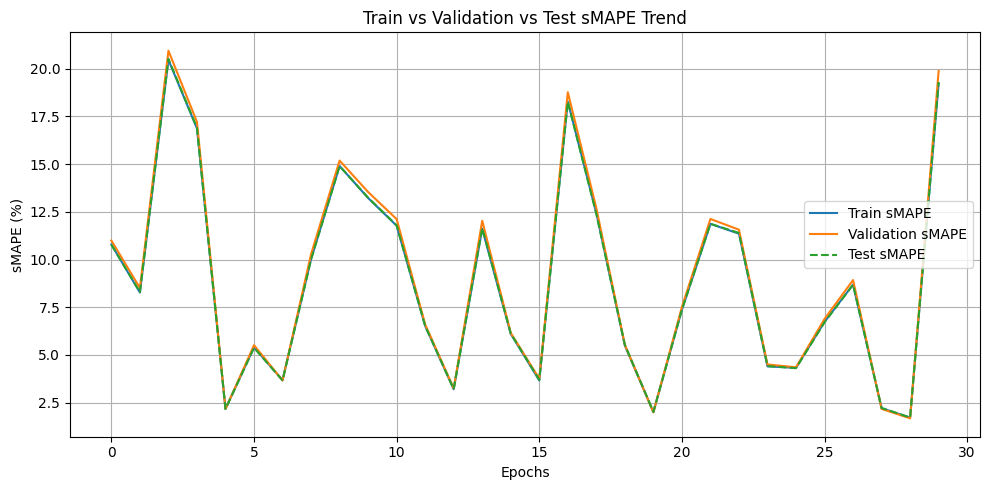

626/626 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step

[최종 Test 평가 결과]
sMAPE : 2.02%
MAE   : 3.1264
RMSE  : 8.9398
R²    : 0.9996


In [9]:
# 다원 방식

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# 데이터 로드 및 전처리
df = pd.read_csv('MLP_sp500_weird.csv')
df = df.dropna(subset=['Close', 'Label', 'Yes_Close', 'Actual_Close']).reset_index(drop=True)

# 정규화 대상: Close, Yes_Close / 정규화 제외: Label
X_numerical = df[['Close', 'Yes_Close']].values
X_label = df[['Label']].values
y = df['Actual_Close'].values.reshape(-1, 1)

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled_num = X_scaler.fit_transform(X_numerical)
X_scaled = np.concatenate([X_scaled_num, X_label], axis=1)
y_scaled = y_scaler.fit_transform(y)

# 학습/검증/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# sMAPE 콜백 정의
class SMAPETracker(Callback):
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test, y_scaler):
        super().__init__()
        self.X_train, self.y_train = X_train, y_train
        self.X_val, self.y_val = X_val, y_val
        self.X_test, self.y_test = X_test, y_test
        self.y_scaler = y_scaler
        self.history = {'train_smape': [], 'val_smape': [], 'test_smape': []}

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.X_train, verbose=0)
        y_val_pred = self.model.predict(self.X_val, verbose=0)
        y_test_pred = self.model.predict(self.X_test, verbose=0)

        y_train_true = self.y_scaler.inverse_transform(self.y_train)
        y_val_true = self.y_scaler.inverse_transform(self.y_val)
        y_test_true = self.y_scaler.inverse_transform(self.y_test)
        y_train_pred = self.y_scaler.inverse_transform(y_train_pred)
        y_val_pred = self.y_scaler.inverse_transform(y_val_pred)
        y_test_pred = self.y_scaler.inverse_transform(y_test_pred)

        def smape(y_true, y_pred):
            return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100

        train_smape = smape(y_train_true, y_train_pred)
        val_smape = smape(y_val_true, y_val_pred)
        test_smape = smape(y_test_true, y_test_pred)

        self.history['train_smape'].append(train_smape)
        self.history['val_smape'].append(val_smape)
        self.history['test_smape'].append(test_smape)

        print(f"Epoch {epoch+1} | Train sMAPE: {train_smape:.2f}% | Val sMAPE: {val_smape:.2f}% | Test sMAPE: {test_smape:.2f}%")

# MLP 모델 구성
mlp = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
smape_tracker = SMAPETracker(X_train_sub, y_train_sub, X_val, y_val, X_test, y_test, y_scaler)

# 모델 학습
mlp.fit(X_train_sub, y_train_sub, epochs=100, batch_size=16,
        validation_data=(X_val, y_val), callbacks=[early_stop, smape_tracker])

# 모델 및 스케일러 저장
# mlp.save('MLP_model_3.h5')
# joblib.dump(X_scaler, 'MLP_X_scaler_3.joblib')
# joblib.dump(y_scaler, 'MLP_y_scaler_3.joblib')

# sMAPE 시각화
plt.figure(figsize=(10, 5))
plt.plot(smape_tracker.history['train_smape'], label='Train sMAPE')
plt.plot(smape_tracker.history['val_smape'], label='Validation sMAPE')
plt.plot(smape_tracker.history['test_smape'], label='Test sMAPE', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('sMAPE (%)')
plt.title('Train vs Validation vs Test sMAPE Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 최종 테스트셋 평가 (실제 단위)
y_test_pred = mlp.predict(X_test)
y_test_rescaled = y_scaler.inverse_transform(y_test)
y_test_pred_rescaled = y_scaler.inverse_transform(y_test_pred)

smape = lambda y, yhat: np.mean(2 * np.abs(y - yhat) / (np.abs(y) + np.abs(yhat) + 1e-8)) * 100
mae = mean_absolute_error(y_test_rescaled, y_test_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_test_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_test_pred_rescaled)

print(f"\n[최종 Test 평가 결과]")
print(f"sMAPE : {smape(y_test_rescaled, y_test_pred_rescaled):.2f}%")
print(f"MAE   : {mae:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R²    : {r2:.4f}")

In [ ]:
# import pandas as pd

# # 원본 데이터 로드
# df = pd.read_csv("MLP_sp500_completed.csv", parse_dates=["Date"])

# # 종목별로 날짜 기준 정렬
# df = df.sort_values(by=["Symbol", "Date"]).reset_index(drop=True)

# # 하루 뒤의 LSTM 예측값을 현재 행과 align시키기 위해 shift(-1)
# df["LSTM_Pred_Close"] = df.groupby("Symbol")["Close"].shift(-1)

# # 하루 뒤가 없는 행은 제거 (즉 종목별 마지막 날짜 제거)
# df_cleaned = df.dropna(subset=["LSTM_Pred_Close"])

# # 컬럼 순서 재정렬
# df_final = df_cleaned[[
#     "Symbol", "Date", "LSTM_Pred_Close", "Label", "Yes_Close", "Actual_Close"
# ]]

# # 새로운 CSV 파일로 저장
# df_final.to_csv("MLP_sp500_weird.csv", index=False)

